# Multimodal retrieval augmentation generation (mRAG)

**_NOTE_**: This notebook has been tested in the following environment:

* Python version = 3.10.13

## Overview

{TODO: Include a paragraph or two explaining what this example demonstrates, who should be interested in it, and what you need to know before you get started.}

Learn more about [web-doc-title](linkback-to-webdoc-page). {TODO: if more than one primary feature, add tag/linkback for each one}

### Objective

In this tutorial, you learn how to {TODO: Complete the sentence explaining briefly what you will learn from the notebook, such as
training, hyperparameter tuning, or serving}:

This notebooks performs best;
- document have both text & images 
- tables in the doc are available as images
- the images don't require too much context. If the document contain particular domain knowledge, make sure to pass that info in the prompt. 

This tutorial uses the following Google Cloud ML services and resources:

- *{TODO: Add high level bullets for the services/resources demonstrated; e.g., Vertex AI Training}*


The steps performed include:

- *{TODO: Add high level bullets for the steps of performed in the notebook}*

### Dataset

{TODO: Include a paragraph with Dataset information and where to obtain it.} 

## Installation

Install the following packages required to execute this notebook. 

Please upgrade to the latest GA version of each package; i.e., --upgrade

In [ ]:
! pip3 install --upgrade --user google-cloud-aiplatform pymupdf rich

In [ ]:
# Restart kernel after installs so that your environment can access the new packages
import IPython
import time

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

## Set up your Google Cloud account and authenticate
Follow the instructions to set up your account and autenticate from [Google's tutorials](https://console.cloud.google.com/cloud-resource-manager). 

In [2]:
# Define project information

import sys

PROJECT_ID = "mRag-on-academic-article"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

# if not running on Colab, try to get the PROJECT_ID automatically
if "google.colab" not in sys.modules:
    import subprocess

    PROJECT_ID = subprocess.check_output(
        ["gcloud", "config", "get-value", "project"], text=True
    ).strip()

print(f"Your project ID is: {PROJECT_ID}")

Your project ID is: gcp-tech-innov-vertexai-6abe


### Import libraries

In [3]:
import sys

# Initialize Vertex AI
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

from IPython.display import Markdown, display
from rich.markdown import Markdown as rich_Markdown
from vertexai.generative_models import (
    Content,
    GenerationConfig,
    GenerationResponse,
    GenerativeModel,
    HarmCategory,
    HarmBlockThreshold,
    Image,
    Part,
)

from intro_multimodal_rag_utils import get_document_metadata

### Initialize the Vertex AI SDK for Python for your project

In [6]:
text_model = GenerativeModel("gemini-1.5-pro")
multimodal_model = GenerativeModel("gemini-1.5-pro-001")
multimodal_model_flash = GenerativeModel("gemini-1.5-flash-001")

## STEP1 - Extracting document metadata from both text and images
To contextualise the search with the images / documents that are interest to us, we need to extract the metadata from our documents. We will then create embeddings to find similar text or image per our prompgt. In addition, the metadata wil be used for references and citations. It includes essencial elements like page numbers, files manes, images counter, etc. 

### STEP 1.1 - Generate Embeddings from the metadata
Embeddings are used to perform similarity search when querying the data. We are extrating metadata from both images and text as there might be information only given in an image and vice versa. 

``` get_document_metadata() ``` : extract text & image metadata from the document. Returns two data frames ```text_metadata``` and ```image_metadata```. 


### STEP 1.2 - Analyse the embeddings 
Using the functions below, check if the embeddings are correct for your data. 
- ```text_metadata```:
    - ```text```: the original text from the page
    - ```text_embedding_page```: the embedding of the original text from the page
    - ```chunk_tex```: the original text divided into smaller chunks
    - ```chunk_number```: the index of each text chunk
    - ```text_embedding_chunk```: the embedding of each text chunk
- ```image_metadata```:
    - ```img_desc```: Gemini-generated textual description of the image.
    - ```mm_embedding_from_text_desc_and_img```: Combined embedding of image and its description, capturing both visual and textual information.
    - ```mm_embedding_from_img_only```: Separate text embedding of the generated description, enabling textual analysis and comparison.

In [11]:
%%time
# pdf_folder_path = "/content/data/" # if running in Google Colab/Colab Enterprise
pdf_folder_path = "data/"  # if running in Vertex AI Workbench.

# Specify the image description prompt. Change it
image_description_prompt = """Explain what is going on in the image.
If it's a table, extract all elements of the table.
If it's a graph, explain the findings in the graph.
Do not include any numbers that are not mentioned in the image.
"""

# Extract text and image metadata from the PDF document
text_metadata_df, image_metadata_df = get_document_metadata(
    multimodal_model,  # we are passing Gemini 1.5 Pro model
    pdf_folder_path,
    image_save_dir="images",
    image_description_prompt=image_description_prompt,
    embedding_size=1408,
    # add_sleep_after_page = True, # Uncomment this if you are running into API quota issues
    # sleep_time_after_page = 5,
    # generation_config = # see next cell
    # safety_settings =  # see next cell
)

print("\n\n --- Completed processing. ---")



 Processing the file: --------------------------------- data/s12885-020-6527-y.pdf 


Processing page: 1
Extracting image from page: 1, saved as: images/s12885-020-6527-y.pdf_image_0_0_229.jpeg
Extracting image from page: 1, saved as: images/s12885-020-6527-y.pdf_image_0_1_230.jpeg
Extracting image from page: 1, saved as: images/s12885-020-6527-y.pdf_image_0_2_231.jpeg
Processing page: 2
Processing page: 3
Processing page: 4
Processing page: 5
Processing page: 6
Extracting image from page: 6, saved as: images/s12885-020-6527-y.pdf_image_5_0_280.jpeg
Processing page: 7
Extracting image from page: 7, saved as: images/s12885-020-6527-y.pdf_image_6_0_309.jpeg
Processing page: 8
Processing page: 9
Extracting image from page: 9, saved as: images/s12885-020-6527-y.pdf_image_8_0_335.jpeg
Processing page: 10
Processing page: 11
Extracting image from page: 11, saved as: images/s12885-020-6527-y.pdf_image_10_0_375.jpeg
Processing page: 12


 --- Completed processing. ---
CPU times: user 1.52 s,

## Inspect metadata

In [12]:
text_metadata_df.head()

,file_name,page_num,text,text_embedding_page,chunk_number,chunk_text,text_embedding_chunk
0,s12885-020-6527-y.pdf,1,RESEARCH ARTICLE\nOpen Access\nSystemic treatm...,"[0.027346676215529442, 0.011194429360330105, -...",1,RESEARCH ARTICLE\nOpen Access\nSystemic treatm...,"[0.0300931204110384, -0.017618391662836075, 0...."
1,s12885-020-6527-y.pdf,1,RESEARCH ARTICLE\nOpen Access\nSystemic treatm...,"[0.027346676215529442, 0.011194429360330105, -...",2,were identified with HR+/HER2- MBC. Median ag...,"[0.014839713461697102, -0.006387830246239901, ..."
2,s12885-020-6527-y.pdf,1,RESEARCH ARTICLE\nOpen Access\nSystemic treatm...,"[0.027346676215529442, 0.011194429360330105, -...",3,ng effective\nand tolerable therapies early.\n...,"[0.03085922822356224, -0.035147421061992645, 0..."
3,s12885-020-6527-y.pdf,1,RESEARCH ARTICLE\nOpen Access\nSystemic treatm...,"[0.027346676215529442, 0.011194429360330105, -...",4,thors.\n1Clinical Cancer Pharmacology and Onco...,"[-0.006659112870693207, 0.02086830325424671, -..."
4,s12885-020-6527-y.pdf,2,Background\nBreast cancer (BC) is biologically...,"[0.01987052708864212, -0.019887985661625862, -...",1,Background\nBreast cancer (BC) is biologically...,"[0.050600361078977585, -0.008597150444984436, ..."


In [13]:
image_metadata_df.head()

,file_name,page_num,img_num,img_path,img_desc,mm_embedding_from_img_only,text_embedding_from_image_description
0,s12885-020-6527-y.pdf,1,1,images/s12885-020-6527-y.pdf_image_0_0_229.jpeg,"The image shows the text ""BMC Cancer"". It is n...","[-0.00392723503, 0.0333488807, 0.0139184939, -...","[-0.00587098253890872, 0.06393181532621384, 0...."
1,s12885-020-6527-y.pdf,1,2,images/s12885-020-6527-y.pdf_image_0_1_230.jpeg,The image is a gray triangle on a white backgr...,"[0.016134385, 0.0502021573, 0.0203378238, 0.01...","[0.03076809085905552, 0.03615700453519821, -0...."
2,s12885-020-6527-y.pdf,1,3,images/s12885-020-6527-y.pdf_image_0_2_231.jpeg,The image is a solid turquoise color. There is...,"[0.00580310496, 0.047959663, 0.00753471861, 0....","[0.022356295958161354, 0.05751033499836922, -0..."
3,s12885-020-6527-y.pdf,6,1,images/s12885-020-6527-y.pdf_image_5_0_280.jpeg,The image consists of a bar graph and a stacke...,"[0.0328628719, 0.000922116451, -0.0658040568, ...","[0.042921897023916245, 0.0058471993543207645, ..."
4,s12885-020-6527-y.pdf,7,1,images/s12885-020-6527-y.pdf_image_6_0_309.jpeg,"The image consists of two donut charts, labele...","[0.0172975417, -0.0215813722, -0.0485824868, -...","[0.07159624993801117, 0.01356556173413992, -0...."


## Import Helper Functions

```/utils/intro_multimodal_rag_utils.py``` includes the helper functions. 

- ```get_similar_text_from_query()```: Given a text query, finds text from the document which are relevant, using cosine similarity algorithm. It uses text embeddings from the metadata to compute and the results can be filtered by top score, page/chunk number, or embedding size.
- ```print_text_to_text_citation()```: Prints the source (citation) and details of the retrieved text from the get_similar_text_from_query() function.
- ```get_similar_image_from_query()```: Given an image path or an image, finds images from the document which are relevant. It uses image embeddings from the metadata.
- ```print_text_to_image_citation()```: Prints the source (citation) and the details of retrieved images from the get_similar_image_from_query() function.
- ```get_gemini_response()```: Interacts with a Gemini model to answer questions based on a combination of text and image inputs.
- ```display_images()```: Displays a series of images provided as paths or PIL Image objects.

In [14]:
from intro_multimodal_rag_utils import (
    get_similar_text_from_query,
    print_text_to_text_citation,
    get_similar_image_from_query,
    print_text_to_image_citation,
    get_gemini_response,
    display_images,
)

## Text Search

Search similar text with text query

In [15]:
query = "How many patients received chemotherapy as first line of therapy"

# Matching user text query with "chunk_embedding" to find relevant chunks.
matching_results_text = get_similar_text_from_query(
    query,
    text_metadata_df,
    column_name="text_embedding_chunk",
    top_n=3,
    chunk_text=True,
)

# Print the matched text citations
print_text_to_text_citation(matching_results_text, print_top=False, chunk_text=True)

Citation 1: Matched text: 

score:  0.75
file_name:  s12885-020-6527-y.pdf
page_number:  5
chunk_number:  1
chunk_text:  60.8% [n = 90], respectively), this difference was not sta-
tistically significant (p = 0.11).
Endocrine therapy
Endocrine therapy was the modality most frequently
used as 1st LoT (n = 127, 68.6%), with a further 12
(6.5%) receiving endocrine/targeted
therapy. Median
treatment duration of 1st LoT endocrine (with/without
targeted) therapy was 382 days (range 131708). Patients
treated with 1st LoT endocrine most commonly received
an AI (114 patients, 82.0%); tamoxifen (8.6%) or exemes-
tane/everolimus in combination (8.6%) were used less
frequently (Table 2).
Chemotherapy
Forty-six patients (24.9%) received 1st LoT chemother-
apy and median treatment duration was 129 days (range
24278). The proportion of patients receiving 1st LoT
chemotherapy appeared to decrease between 2012 and
2017 (33.3 and 15.4%, respectively), although this trend
was not statistically significan

In [16]:
print("\n **** Result: ***** \n")

# All relevant text chunk found across documents based on user query
context = "\n".join(
    [value["chunk_text"] for key, value in matching_results_text.items()]
)

instruction = f"""Answer the question with the given context.
If the information is not available in the context, just return "not available in the context".
Question: {query}
Context: {context}
Answer:
"""

# Prepare the model input
model_input = instruction

# Generate Gemini response with streaming output
get_gemini_response(
    text_model,  # we are passing Gemini 1.0 Pro
    model_input=model_input,
    stream=True,
    generation_config=GenerationConfig(temperature=0.2),
)


 **** Result: ***** 



'Forty-six patients received chemotherapy as the first line of therapy. \n'

## Search for similar images with text query


 **** Result: ***** 



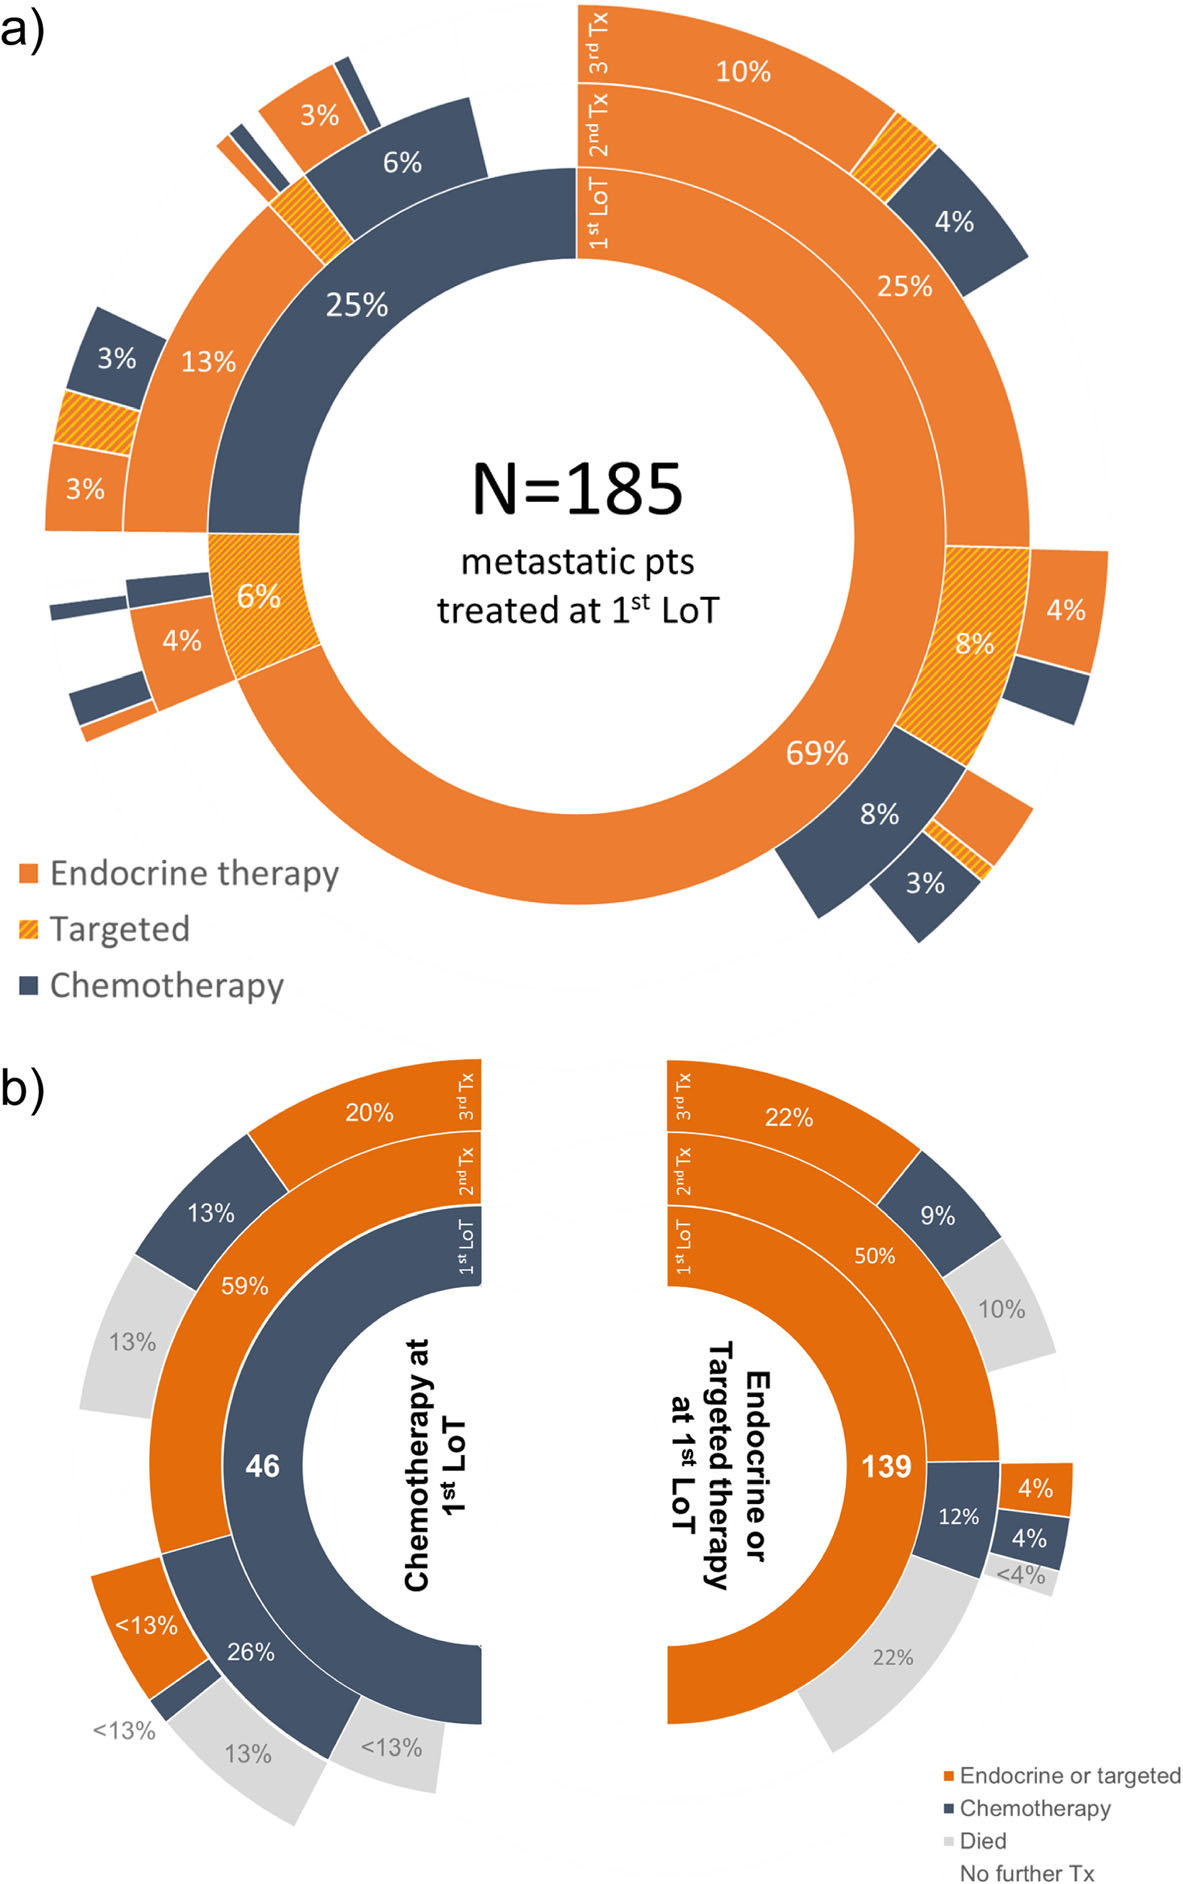

In [17]:
query = "How many patients received chemotherapy as first line of therapy"

matching_results_image = get_similar_image_from_query(
    text_metadata_df,
    image_metadata_df,
    query=query,
    column_name="text_embedding_from_image_description",  # Use image description text embedding
    image_emb=False,  # Use text embedding instead of image embedding
    top_n=3,
    embedding_size=1408,
)

# Markdown(print_text_to_image_citation(matching_results_image, print_top=True))
print("\n **** Result: ***** \n")

# Display the top matching image
display(matching_results_image[0]["image_object"])

In [18]:
print("\n **** Result: ***** \n")

# All relevant text chunk found across documents based on user query
context = f"""Image: {matching_results_image[0]['image_object']}
Description: {matching_results_image[0]['image_description']}
"""

instruction = f"""Answer the question in JSON format with the given context of Image and its Description. Only include value.
Question: {query}
Context: {context}
Answer:
"""

# Prepare the model input
model_input = instruction

# Generate Gemini response with streaming output
Markdown(
    get_gemini_response(
        multimodal_model_flash,  # we are passing Gemini 1.5 Pro Flash
        model_input=model_input,
        stream=True,
        generation_config=GenerationConfig(temperature=1),
    )
)


 **** Result: ***** 



185


In [19]:
## you can check the citations to probe further.
## check the "image description:" which is a description extracted through Gemini which helped search our query.
Markdown(print_text_to_image_citation(matching_results_image, print_top=True))

Citation 1: Matched image path, page number and page text: 

score:  0.7
file_name:  s12885-020-6527-y.pdf
path:  images/s12885-020-6527-y.pdf_image_6_0_309.jpeg
page number:  7
page text:  chemotherapy (n = 28, 22.6%) (Fig. 2a). When given, 3rd
LoT was again more often endocrine (with/without tar-
geted) therapy (n = 49, 65.3%) than chemotherapy (n =
26, 34.7%).
There was substantial diversity in the sequence of
SACT classes and regimens used (Additional file 2). One
line of endocrine therapy with a single agent AI, was the
treatment sequence used most frequently (27.6%, n = 51
patients). The next most common were three successive
lines (n = 19, 10.3%) and two successive lines (n = 17,
9.2%) of endocrine therapy, each without targeted ther-
apy. The fourth most common treatment sequence was
the first to include chemotherapy, (3rd LoT capecitabine
following endocrine therapy; n = 8, 4.3%).
Patients receiving 1st LoT chemotherapy were more
likely
than those
receiving endocrine
(with/wit

<IPython.core.display.Markdown object>

### Build mRAG

1. Step 1
2. Step 2

#### Step 1: User Prompt

In [20]:
# this time we are not passing any images, but just a simple text query.

query = """Questions:
 - How many patients with metastasis recived endoctine therapy as 1st LoT?
 - Can you summarise the paper in 3 sentences?
 - Who are the authors and their corresponsing institutions?
 - Summary of the patient population
 - Which patient group has the highest survival rate?
 - Which treatment group has the highest survival rate?
 """

#### Step 2: Get all relevant text chunks & Step 3: Get all relevant images


In [21]:
# Retrieve relevant chunks of text based on the query
matching_results_chunks_data = get_similar_text_from_query(
    query,
    text_metadata_df,
    column_name="text_embedding_chunk",
    top_n=10,
    chunk_text=True,
)

# Retrieve relevant chunks of text based on the query
matching_results_chunks_data = get_similar_text_from_query(
    query,
    text_metadata_df,
    column_name="text_embedding_chunk",
    top_n=10,
    chunk_text=True,
)

# Get all relevant images based on user query
matching_results_image_fromdescription_data = get_similar_image_from_query(
    text_metadata_df,
    image_metadata_df,
    query=query,
    column_name="text_embedding_from_image_description",
    image_emb=False,
    top_n=10,
    embedding_size=1408,
)

In [22]:
# Get all relevant images based on user query
matching_results_image_fromdescription_data = get_similar_image_from_query(
    text_metadata_df,
    image_metadata_df,
    query=query,
    column_name="text_embedding_from_image_description",
    image_emb=False,
    top_n=10,
    embedding_size=1408,
)

### Step 4: Create context_text and context_images

In [ ]:
# combine all the selected relevant text chunks
context_text = []
for key, value in matching_results_chunks_data.items():
    context_text.append(value["chunk_text"])
final_context_text = "\n".join(context_text)

# combine all the relevant images and their description generated by Gemini
context_images = []
for key, value in matching_results_image_fromdescription_data.items():
    context_images.extend(
        ["Image: ", value["image_object"], "Caption: ", value["image_description"]]
    )

# combine all the selected relevant text chunks
context_text = []
for key, value in matching_results_chunks_data.items():
    context_text.append(value["chunk_text"])
final_context_text = "\n".join(context_text)

# combine all the relevant images and their description generated by Gemini
context_images = []
for key, value in matching_results_image_fromdescription_data.items():
    context_images.extend(
        ["Image: ", value["image_object"], "Caption: ", value["image_description"]]
    )

### Step 5: Pass context to Gemini

prompt = f""" Instructions: Compare the images and the text provided as Context: to answer multiple Question:
Make sure to think thoroughly before answering the question and put the necessary steps to arrive at the answer in bullet points for easy explainability.
If unsure, respond, "Not enough context to answer".

Context:
 - Text Context:
 {final_context_text}
 - Image Context:
 {context_images}

{query}

Answer:
"""

# Generate Gemini response with streaming output
rich_Markdown(
    get_gemini_response(
        multimodal_model,
        model_input=[prompt],
        stream=True,
        generation_config=GenerationConfig(temperature=1),
    )
)

## Conclusions